In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import copy
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

cuda


In [2]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

transform_val = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    ])
train_set = datasets.ImageFolder(r"C:\Users\pirat\Desktop\archive (5)\chest_xray\train", transform = transform_train)
val_set = datasets.ImageFolder(r"C:\Users\pirat\Desktop\archive (5)\chest_xray\val", transform = transform_val)
test_set= datasets.ImageFolder(r"C:\Users\pirat\Desktop\archive (5)\chest_xray\test",transform=transform_test)

In [3]:
num_classes = 2
batch_size = 8
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Use `next()` directly on the iterator

print(images.shape)
print(images[1].shape)
print(labels[1].item())

print("Classes in the training set:")
print(train_set.classes)
print("Classes in the validation set:")
print(val_set.classes)


torch.Size([8, 3, 224, 224])
torch.Size([3, 224, 224])
1
Classes in the training set:
['NORMAL', 'PNEUMONIA']
Classes in the validation set:
['NORMAL', 'PNEUMONIA']


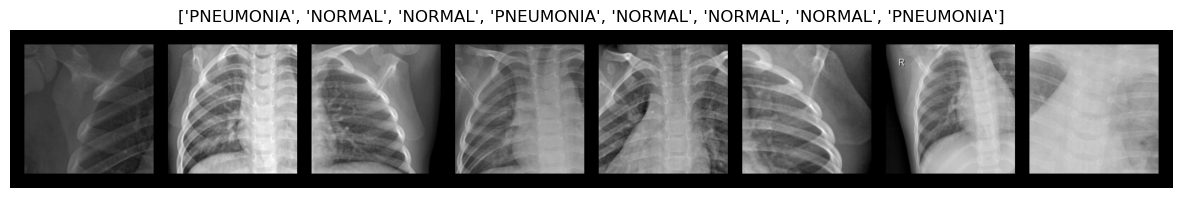

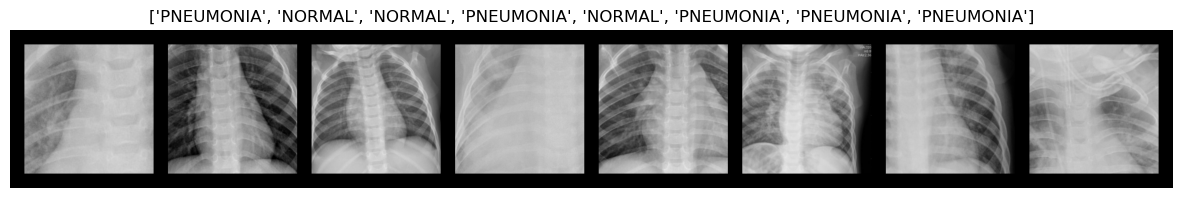

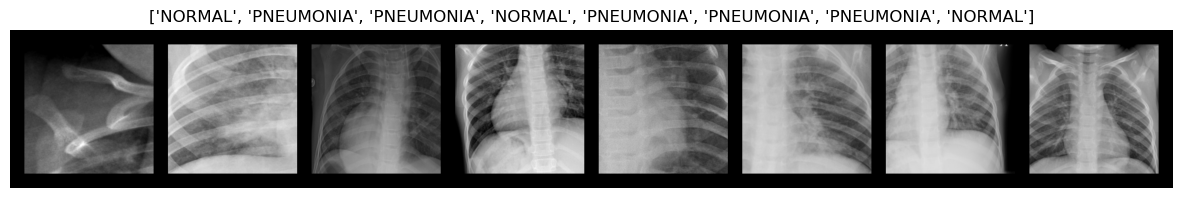

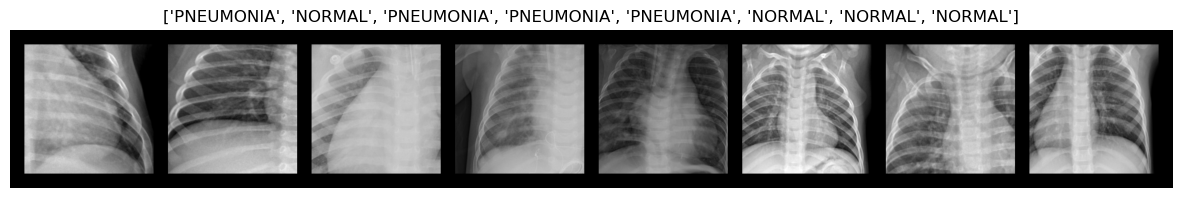

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images,padding=25)
    imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])

for i in range(4):
    show_batch_images(trainloader)

# Transfer learning and training VGG19

In [6]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return (100 * correct / total)

In [7]:
vgg19 = models.vgg19_bn(pretrained=True)
for param in vgg19.parameters():
    param.requires_grad = False

final_in_features = vgg19.classifier[6].in_features
num_classes = len(train_set.classes)  # Make sure num_classes is defined correctly
vgg19.classifier[6] = nn.Linear(final_in_features, num_classes)
for param in vgg19.parameters():
    if param.requires_grad:
        print(param.shape)

vgg19 = vgg19.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg19.parameters(), lr=0.01)

C:\Users\pirat\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pirat\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([2, 4096])
torch.Size([2])


In [ ]:
%%time

loss_epoch_arr = []
max_epochs = 20

min_loss = 10000000

n_iters = np.ceil(len(trainloader.dataset) / batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg19(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg19.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

vgg19.load_state_dict(best_model)
print(evaluation(trainloader, vgg19), evaluation(valloader, vgg19))

Min loss 0.69
Iteration: 0/652, Loss: 0.69
Min loss 0.44
Min loss 0.10
Min loss 0.09
Min loss 0.08
Min loss 0.03
Min loss 0.01
Iteration: 100/652, Loss: 0.60
Min loss 0.01
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Iteration: 200/652, Loss: 0.85
Iteration: 300/652, Loss: 1.53
Iteration: 400/652, Loss: 0.54
Iteration: 500/652, Loss: 0.00
Iteration: 600/652, Loss: 1.39
Iteration: 0/652, Loss: 0.04
Iteration: 100/652, Loss: 6.06
Iteration: 200/652, Loss: 1.85
Iteration: 300/652, Loss: 0.71
Iteration: 400/652, Loss: 0.24
Iteration: 500/652, Loss: 0.55
Iteration: 600/652, Loss: 0.00
Iteration: 0/652, Loss: 0.00
Iteration: 100/652, Loss: 0.76
Iteration: 200/652, Loss: 0.61
Iteration: 300/652, Loss: 0.64
Iteration: 400/652, Loss: 3.00
Iteration: 500/652, Loss: 3.47
Iteration: 600/652, Loss: 0.74
Iteration: 0/652, Loss: 3.98
Iteration: 100/652, Loss: 0.00
Iteration: 200/652, Loss: 1.06
Iteration: 300/652, Loss: 2.84
Iteration: 400/652, Los